This notebook will be used to compare the tidal ellipses of the hourly data and the 15 minute data at the VENUS nodes. This notebook will be very similar to Exploring Tidal Ellipses at VENUS nodes

#Loading the Hourly Data

In [1]:
import os
import glob
import datetime
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
import numpy as np
from IPython.display import display, Math, Latex

import netCDF4 as nc
from scipy.optimize import curve_fit
from salishsea_tools import (viz_tools,tidetools, nc_tools)
from salishsea_tools.nowcast import research_VENUS

%matplotlib inline

In [2]:
grid_B = nc.Dataset('/data/dlatorne/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
lats = grid_B.variables['nav_lat'][:]
lons = grid_B.variables['nav_lon'][:]
bathy = grid_B.variables['Bathymetry'][:,:]

In [3]:
def combine_hourly(files, var, station):
    """function to combine a model variable from a list of many files. 
    Returns an array of the variable and associated model times.
    Only for variables over depth.
    """
    if station =='Central':
        i=266
        j=424
    else:
        i=283
        j=416

    #empty arrays
    time = np.array([])
    var_list=[]

    for f in files:
        G = nc.Dataset(f)
        var_tmp = G.variables[var][:,:,j-1:j+1,i-1:i+1]
        #append variable to array
        var_list.append(var_tmp)
        t = nc_tools.timestamp(G, np.arange(var_tmp.shape[0]))
        for ind in range(len(t)):
            t[ind] = t[ind].datetime
        time = np.append(time, t)
        
    var_ary=np.concatenate(var_list,axis=0)
    return var_ary,time

In [4]:
def combine_t(files, var):
    """function to combine a model variable from a list of many files. 
    Returns an array of the variabel and associated model times.
    Only for variables with one dimension, ex: time counter and depth
    """
    #empty arrays
    time = np.array([])
    var_list=[]

    for f in files:
        G = nc.Dataset(f)
        var_tmp = G.variables[var][:]
        #append variable to array
        var_list.append(var_tmp)
        
    var_ary=np.concatenate(var_list,axis=0)
    return var_ary

In [5]:
path = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
filesu = glob.glob(os.path.join(path,'*','*_1h_*_grid_U*'))
filesu = []
files_East = glob.glob(os.path.join(path,'*','VENUS_east_gridded.nc'))
for f in files_East:
    directory=os.path.dirname(f)
    filesu.append(glob.glob(os.path.join(directory,'*_1h_*_grid_U*'))[0])
filesu.sort(key=os.path.basename)


filesv = glob.glob(os.path.join(path,'*','*_1h_*_grid_V*'))
filesv = []
files_East = glob.glob(os.path.join(path,'*','VENUS_east_gridded.nc'))
for f in files_East:
    directory=os.path.dirname(f)
    filesv.append(glob.glob(os.path.join(directory,'*_1h_*_grid_V*'))[0])
filesv.sort(key=os.path.basename)

In [6]:
t=5
datas=t
dot=len(filesu)-datas
filesu=filesu[dot:]
filesv=filesv[dot:]

In [7]:
u_u_c, time = combine_hourly(filesu, 'vozocrtx', 'Central')
v_v_c, time = combine_hourly(filesv, 'vomecrty', 'Central')
time_c = combine_t(filesu, 'time_counter')
dep_t_c = combine_t(filesv, 'depthv')
time_c = time_c/3600

u_u_e, time = combine_hourly(filesu,'vozocrtx', 'East')
v_v_e, time = combine_hourly(filesv,'vomecrty', 'East')
time_e = combine_t(filesu, 'time_counter')
dep_t_e = combine_t(filesv, 'depthv')
time_e = time_e/3600

u_u_c.shape

(120, 40, 2, 2)

In [8]:
u_c, v_c=research_VENUS.unstag_rot_gridded(u_u_c, v_v_c, 'Central')
u_e, v_e=research_VENUS.unstag_rot_gridded(u_u_e, v_v_e, 'East')
u_c.shape

(120, 40)

#Setting up the tides

In [9]:
M2freq = 28.984106 # degrees per hour
M2freq = M2freq*np.pi/180. # radians per hour
K1freq = 15.041069*np.pi/180.

thesize=40

vM2amp = np.zeros(thesize); vM2pha = np.zeros(thesize)
vK1amp = np.zeros(thesize); vK1pha = np.zeros(thesize)
uM2amp = np.zeros(thesize); uM2pha = np.zeros(thesize)
uK1amp = np.zeros(thesize); uK1pha = np.zeros(thesize)

In [10]:
# function for fit, this assumes two tides only
def double(x, M2amp, M2pha, K1amp, K1pha, mean):
    return (mean + M2amp*np.cos(M2freq*x-M2pha*np.pi/180.)+
            K1amp*np.cos(K1freq*x-K1pha*np.pi/180.))

In [11]:
# function to do the fitting and actually find the tidal components
def fittit (uaus, vaus, time):
    for dep in np.arange(0,39):
        if vaus[:,dep].any() != 0.:
            fitted, cov = curve_fit(double,time[:],vaus[:,dep]) 
        if fitted[0] < 0:
            fitted[0] = -fitted[0]
            fitted[1] = fitted[1]+180.
        if fitted[1] > 180:
            fitted[1] = fitted[1] - 360.
        elif fitted[1] < -180-360:
            fitted[1] = fitted[1] + 720.
        elif fitted [1] < -180:
            fitted[1] = fitted[1] + 360.
        if fitted[2] < 0:
            fitted[2] = -fitted[2]
            fitted[3] = fitted[3]+180.
        vM2amp[dep] = fitted[0]
        vM2pha[dep] = fitted[1]
        vK1amp[dep] = fitted[2]
        vK1pha[dep] = fitted[3]

    for dep in np.arange(0,39):
        if uaus[:,dep].any() !=0.:
            fitted, cov = curve_fit(double,time[:],uaus[:,dep]) 
        if fitted[0] < 0:
            fitted[0] = -fitted[0]
            fitted[1] = fitted[1]+180.
        if fitted[1] > 180+360:
            fitted[1] = fitted[1] -720
        elif fitted[1] > 180:
            fitted[1] = fitted[1] - 360.
        elif fitted[1] < -180-360:
            fitted[1] = fitted[1] + 720.
        elif fitted [1] < -180:
            fitted[1] = fitted[1] + 360.
        if fitted[2] < 0:
            fitted[2] = -fitted[2]
            fitted[3] = fitted[3]+180.
        uM2amp[dep] = fitted[0]
        uM2pha[dep] = fitted[1]
        uK1amp[dep] = fitted[2]
        uK1pha[dep] = fitted[3]
    return vM2amp, vM2pha, vK1amp, vK1pha, uM2amp, uM2pha, uK1amp, uK1pha

In [12]:
# this function calculates ellipse parameters based on the amplitude and phase.  From Foreman (1977)
def ellipse_params (uM2amp, uM2pha, vM2amp, vM2pha):
    CX = uM2amp*np.cos(np.pi*uM2pha/180.)
    SX = uM2amp*np.sin(np.pi*uM2pha/180.)
    CY = vM2amp*np.cos(np.pi*vM2pha/180.)
    SY = vM2amp*np.sin(np.pi*vM2pha/180.)
    ap = np.sqrt((CX+SY)**2+(CY-SX)**2)/2.  # amplitude of positively rotating component
    am = np.sqrt((CX-SY)**2+(CY+SX)**2)/2.  # amplitude of negatively rotating component
    ep = np.arctan2(CY-SX,CX+SY)+np.pi       # phase of positive
    em = np.arctan2(CY+SX,CX-SY)+np.pi      # phase of negative
    major = ap+am                           # major axis
    minor = ap-am                           # signed minor axis
    theta = (ep+em)/2.*180./np.pi           # axis tilt
    theta %= 180                             # by convention theta is between 0 and 180.
    return CX, SX, CY, SY, ap, am, ep, em, major, minor, theta

In [13]:
vM2ampc, vM2phac, vK1ampc, vK1phac, uM2ampc, uM2phac, uK1ampc, uK1phac = fittit (u_c, v_c, 
                                                                         time_c)

CX_c, SX_c, CY_c, SY_c, ap_c, am_c, ep_c, em_c, major_c, minor_c, theta_c = ellipse_params (uM2ampc, uM2phac, vM2ampc, vM2phac)
CX_ck, SX_ck, CY_ck, SY_ck, ap_ck, am_ck, ep_ck, em_ck, major_ck, minor_ck, theta_ck = ellipse_params (uK1ampc, uK1phac, vK1ampc, vK1phac)

In [14]:
vM2ampe, vM2phae, vK1ampe, vK1phae, uM2ampe, uM2phae, uK1ampe, uK1phae = fittit (u_e, v_e, 
                                                                         time_e)
CX_e, SX_e, CY_e, SY_e, ap_e, am_e, ep_e, em_e, major_e, minor_e, theta_e= ellipse_params (uM2ampe, uM2phae, vM2ampe, vM2phae)

CX_ek, SX_ek, CY_ek, SY_ek, ap_ek, am_ek, ep_ek, em_ek, major_ek, minor_ek, theta_ek= ellipse_params (uK1ampe, uK1phae, vK1ampe, vK1phae)

#Plots

red is clockwise


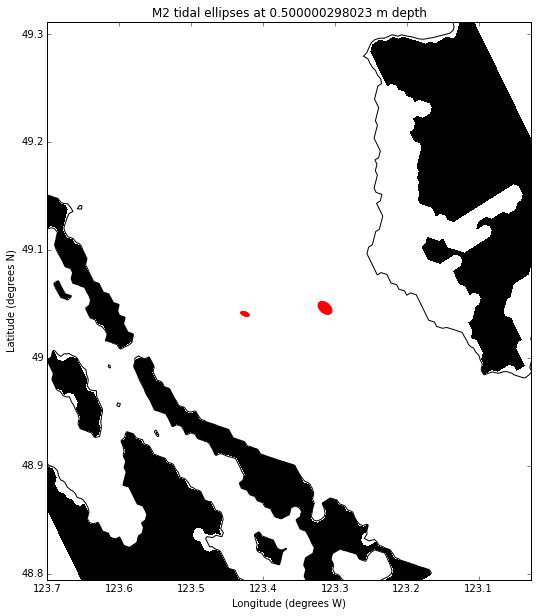

In [15]:
# rotate grid, then label axes in lats/longs

phi = 29. # the twist in the grid
k = np.zeros((898,398)); m = np.zeros((898,398))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
viz_tools.set_aspect(ax) 
ex = 60

#Inverted i and j to match code
imin=416 #East node y
imax=424 #Central mode y
jmin=266 #East node x
jmax=283 #Central node x

for i in np.arange(imin-ex,imax+ex):
    for j in np.arange(jmin-ex,jmax+ex):
        k[i,j] = i*np.cos(phi*np.pi/180.)+j*np.sin(phi*np.pi/180.)
        m[i,j] = -i*np.sin(phi*np.pi/180.)+j*np.cos(phi*np.pi/180.) 
scale = 8.
interval = 4
depth=0
#Making the ellipse for the Central node
if ap_c[depth] > am_c[depth]:
    thec1 = 'b'
else:
    thec1 = 'r'
ells1 = Ellipse(xy=(m[imax,jmin],k[imax,jmin]), width=scale*major_c[depth], 
    height=scale*minor_c[depth], angle=theta_c[depth]+29.,
    color=thec1)

#Making the ellipse for the East node
if ap_e[depth] > am_e[depth]:
    thec2 = 'b'
else:
    thec2 = 'r'
ells2 = Ellipse(xy=(m[imin,jmax],k[imin,jmax]), width=scale*major_e[depth], 
    height=scale*minor_e[depth], angle=theta_e[depth]+29.,
    color=thec2)
    
    
ax.add_artist(ells1)
ax.add_artist(ells2)
ells1.set_facecolor(thec1)
ells2.set_facecolor(thec2)
# y-axis in k, but labelled in latitude
ax.set_ylim(445,560)
slope = (lats[imax,jmin]-lats[imin,jmin])/(k[imax,jmin]-k[imin,jmin])
mylist = (k[imin,jmin]+(np.arange(48.8, 49.35, 0.1)-
                           lats[imin,jmin])/slope).tolist()
labels = ['48.8', '48.9', '49', '49.1', '49.2', '49.3']
ax.set_yticks(mylist); ax.set_yticklabels(labels)
ax.set_ylabel('Latitude (degrees N)')
# x-axis in m, but labelled in longitude
ax.set_xlim(-14,94)
slope = (lons[imin,jmax]-lons[imin,jmin])/(m[imin,jmax]-m[imin,jmin])
mylist = (m[imin,jmin]+(np.arange(-123.7,-123.05,0.1)-
                        lons[imin,jmin])/slope).tolist()
labels = ['123.7','123.6','123.5','123.4','123.3','123.2','123.1','123']
ax.set_xticks(mylist); ax.set_xticklabels(labels)
ax.set_xlabel('Longitude (degrees W)')


# land, and 5 m contour
contour_interval = [-0.01, 0.01]
ax.contourf(m[imin-ex:imax+ex,jmin-ex:jmax+ex],k[imin-ex:imax+ex,jmin-ex:jmax+ex],
            bathy.data[imin-ex:imax+ex,jmin-ex:jmax+ex],contour_interval,colors='black')
ax.contour(m[imin-ex:imax+ex,jmin-ex:jmax+ex],k[imin-ex:imax+ex,jmin-ex:jmax+ex],
            bathy.data[imin-ex:imax+ex,jmin-ex:jmax+ex],[5],colors='black')
ax.set_title('M2 tidal ellipses at {dep} m depth'.format(dep=dep_t_c[depth]))

print "red is clockwise"

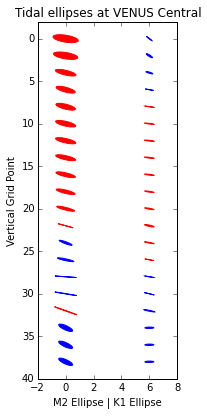

In [16]:
fig = plt.figure(figsize=(5.5,6.4))
ax = fig.add_subplot(121)
scale = 7
interval = 2

for dep in np.arange(0,40,interval):
    if ap_c[dep] > am_c[dep]:
        thec = 'b'
    else:
        thec = 'r'
    ells = Ellipse(xy=(0,dep), width=scale*major_c[dep], 
                        height=scale*minor_c[dep], angle=-theta_c[dep]-29,
                        color=thec)
    ax.add_artist(ells)
    ells.set_facecolor(thec)
    
for dep in np.arange(0,40,interval):
    if ap_ck[dep] > am_ck[dep]:
        thec = 'b'
    else:
        thec = 'r'
    ells = Ellipse(xy=(6,dep), width=scale*major_ck[dep], 
                        height=scale*minor_ck[dep], angle=-theta_ck[dep]-29,
                        color=thec)
    ax.add_artist(ells)
    ells.set_facecolor(thec)
ax.set_ylim(-2,40)
ax.invert_yaxis()
ax.set_xlim(-2,8)
ax.set_title('Tidal ellipses at VENUS Central')
ax.set_ylabel('Vertical Grid Point')
ax.set_xlabel('M2 Ellipse | K1 Ellipse')

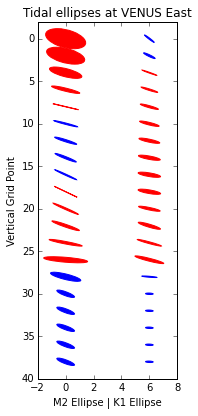

In [17]:
fig = plt.figure(figsize=(5.5,6.4))
ax = fig.add_subplot(121)
scale = 7
interval = 2

for dep in np.arange(0,40,interval):
    if ap_e[dep] > am_e[dep]:
        thec = 'b'
    else:
        thec = 'r'
    ells = Ellipse(xy=(0,dep), width=scale*major_e[dep], 
                        height=scale*minor_e[dep], angle=-theta_e[dep]-29,
                        color=thec)
    ax.add_artist(ells)
    ells.set_facecolor(thec)
    
for dep in np.arange(0,40,interval):
    if ap_ek[dep] > am_ek[dep]:
        thec = 'b'
    else:
        thec = 'r'
    ells = Ellipse(xy=(6,dep), width=scale*major_ek[dep], 
                        height=scale*minor_ek[dep], angle=-theta_ek[dep]-29,
                        color=thec)
    ax.add_artist(ells)
    ells.set_facecolor(thec)
ax.set_ylim(-2,40)
ax.invert_yaxis()
ax.set_xlim(-2,8)
ax.set_title('Tidal ellipses at VENUS East')
ax.set_ylabel('Vertical Grid Point')
ax.set_xlabel('M2 Ellipse | K1 Ellipse')

#Compare with a table

For M2 constituent

In [18]:
print "                     Central                         East"
print "Depth    Major-Axis  Minor-Axis  Angle   Major-Axis  Minor-Axis  Angle "
print " (m)        (m/s)      (m/s)     (deg.    (m/s)       (m/s)      (deg."
print "                                 ccw E)                          ccw E)"
for i in np.arange(0,39,interval):
    print '{0:5.1f}      {1:.2f}        {2:.2f}       {3:.0f}      {4:.2f}       {5:.2f}       {6:.0f}'.format(dep_t_c[i], 
                                                      major_c[i], minor_c[i], theta_c[i]+29, major_e[i], minor_e[i],  theta_e[i]+29)

                     Central                         East
Depth    Major-Axis  Minor-Axis  Angle   Major-Axis  Minor-Axis  Angle 
 (m)        (m/s)      (m/s)     (deg.    (m/s)       (m/s)      (deg.
                                 ccw E)                          ccw E)
  0.5      0.27        -0.11       163      0.45       -0.28       148
  2.5      0.26        -0.10       163      0.43       -0.23       152
  4.5      0.23        -0.08       158      0.36       -0.13       156
  6.5      0.21        -0.08       154      0.31       -0.05       158
  8.5      0.22        -0.08       155      0.28       -0.00       159
 10.5      0.22        -0.08       157      0.26       0.02       157
 12.5      0.22        -0.07       159      0.25       0.03       152
 14.6      0.22        -0.07       159      0.26       0.03       147
 16.8      0.21        -0.06       158      0.28       0.02       143
 19.5      0.21        -0.05       158      0.30       -0.00       142
 24.1      0.20      

For K1 constituent

In [19]:
print "                     Central                         East"
print "Depth    Major-Axis  Minor-Axis  Angle   Major-Axis  Minor-Axis  Angle "
print " (m)        (m/s)      (m/s)     (deg.    (m/s)       (m/s)      (deg."
print "                                 ccw E)                          ccw E)"
for i in np.arange(0,39,interval):
    print '{0:5.1f}      {1:.2f}        {2:.2f}       {3:.0f}      {4:.2f}       {5:.2f}       {6:.0f}'.format(dep_t_c[i], 
                                                      major_ck[i], minor_ck[i], theta_ck[i]+29, major_ek[i], minor_ek[i],  theta_ek[i]+29)

                     Central                         East
Depth    Major-Axis  Minor-Axis  Angle   Major-Axis  Minor-Axis  Angle 
 (m)        (m/s)      (m/s)     (deg.    (m/s)       (m/s)      (deg.
                                 ccw E)                          ccw E)
  0.5      0.09        0.01       129      0.16       0.02       128
  2.5      0.09        0.02       132      0.15       0.03       141
  4.5      0.08        0.02       153      0.17       -0.01       150
  6.5      0.09        0.00       164      0.19       -0.02       153
  8.5      0.10        -0.01       167      0.20       -0.03       155
 10.5      0.10        -0.01       168      0.22       -0.04       158
 12.5      0.10        -0.01       169      0.22       -0.05       160
 14.6      0.10        -0.01       169      0.23       -0.06       163
 16.8      0.10        -0.01       168      0.24       -0.06       164
 19.5      0.10        -0.01       167      0.24       -0.06       164
 24.1      0.10        

It is very similar to the 15 minutes data, only a few very slight changes, generally in the Major Axis or Minor Axis and the East node has a tendency to have more difference, maybe because the values tend to be larger. 
The longer the time the ellipses are averaged over the more the 15 minutes data and the hourly data are similar.
No change with K1 values